## Purpose
This notebook imports images and their labels from the ai_club team folder and exports the images, cropped to their ROI. Then it creates synthetic data by stretching both the left and right vocal cords.


In [4]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import imagesize
from PIL import Image, ImageFilter

In [5]:
# define input/output folders
source_folder = '/data/ai_club/team_13_2024-25/VIPR/Data'
images_folder = os.path.join(source_folder,'YOLO_images_total')
labels_folder = os.path.join(source_folder,'YOLO_labels_total')
output_folder = 'ROI_cropped_images'

In [6]:
image_list = os.listdir(images_folder)

image_path_list = [os.path.join(images_folder,image) for image in os.listdir(images_folder)]
label_path_list = [os.path.join(labels_folder,label) for label in os.listdir(labels_folder)]

In [7]:
def blend_halves_bilinear(left_img, right_img, blend_width=10):
    """
    Combine left_img and right_img without removing any pixels in the overlapping region.
    The overlapping seam is defined as the rightmost blend_width columns of left_img and
    the leftmost blend_width columns of right_img. These two regions are first resampled
    using bilinear interpolation to a common width (2*blend_width), then blended together
    with a 2D alpha mask that transitions smoothly from 0 (left image) to 1 (right image).
    """
    width_left, height = left_img.size
    width_right, _ = right_img.size

    # Create composite image: paste left_img fully, then right_img fully shifted.
    total_width = width_left + width_right
    composite = Image.new(left_img.mode, (total_width, height))
    composite.paste(left_img, (0, 0))
    composite.paste(right_img, (width_left, 0))

    # Define the seam region in the composite:
    seam_start = width_left - blend_width  # start of overlap in composite
    seam_width = 2 * blend_width            # full width of overlap region

    # Extract the overlapping regions:
    left_overlap = left_img.crop((width_left - blend_width, 0, width_left, height))
    right_overlap = right_img.crop((0, 0, blend_width, height))

    # Resample each overlap to a common region of width = 2*blend_width using bilinear interpolation.
    left_resized = left_overlap.resize((seam_width, height), resample=Image.Resampling.BILINEAR)
    right_resized = right_overlap.resize((seam_width, height), resample=Image.Resampling.BILINEAR)

    # Convert to numpy arrays (float32 for interpolation math)
    left_arr = np.array(left_resized, dtype=np.float32)
    right_arr = np.array(right_resized, dtype=np.float32)

    # Create a 2D alpha mask for blending.
    # Here the mask is purely horizontal—every row gets the same gradient from 0 (left) to 1 (right).
    # (If desired you could incorporate a vertical component too.)
    alpha = np.tile(np.linspace(0, 1, seam_width), (height, 1))
    
    # Blend the two resampled overlap regions using the alpha mask.
    # For each pixel: blended = (1 - alpha) * left_pixel + alpha * right_pixel.
    blended_region = (1 - alpha)[..., None] * left_arr + alpha[..., None] * right_arr

    # Convert back to a PIL Image.
    blended_region_img = Image.fromarray(np.clip(blended_region, 0, 255).astype(np.uint8), mode=left_img.mode)
    
    # Paste the blended seam back into the composite image.
    composite.paste(blended_region_img, (seam_start, 0))

    return composite

In [9]:
def crop_and_stretch(image_path, label_path, scaleFactor=1.2, blend_width=10):
    """Crops a 256x256 image to the region of interest (ROI) specified by the label file and resizes it back to 256x256."""
    # Verify that the image and label file have matching base names.
    image_base = os.path.splitext(os.path.basename(image_path))[0]
    label_base = os.path.splitext(os.path.basename(label_path))[0]
    if image_base != label_base:
        raise ValueError("Image file and label file names do not match.")

    # Open the image.
    image = Image.open(image_path)
    if image.size != (256, 256):
        raise ValueError("The input image is not 256x256 in size.")

    # Read and parse the label file.
    with open(label_path, 'r') as f:
        line = f.readline().strip()
        parts = line.split()
        if len(parts) != 5:
            raise ValueError("Label file does not contain exactly 5 values.")
        # Parse values: ignoring the first value which represents the class label.
        try:
            _, x_center, y_center, box_width, box_height = parts
            x_center = float(x_center)
            y_center = float(y_center)
            box_width = float(box_width)
            box_height = float(box_height)
        except ValueError:
            raise ValueError("One or more of the coordinate values are not valid floats.")

    # Calculate pixel coordinates for cropping.
    img_width, img_height = image.size
    left   = int((x_center - box_width / 2) * img_width)
    top    = int((y_center - box_height / 2) * img_height)
    right  = int((x_center + box_width / 2) * img_width)
    bottom = int((y_center + box_height / 2) * img_height)
    bottom_stretched = int((y_center + (box_height*scaleFactor) / 2) * img_height)
    mid = int(x_center * img_width)
    
    # Ensure coordinates are within image boundaries.
    left = max(0, left)
    top = max(0, top)
    right = min(img_width, right)
    bottom = min(img_height, bottom)
    bottom_stretched = min(img_height, bottom_stretched)
    stretched_height = bottom_stretched - top

    # Crop the image to the region of interest.
    cropped_image = image.crop((left, top, right, bottom))
    
    # Split image into left and right halves
    left_half = image.crop((left,top,mid,bottom))
    right_half = image.crop((mid,top,right,bottom))
    
    # Create extended halves
    left_half_ext = image.crop((left,top,mid,bottom_stretched))
    right_half_ext = image.crop((mid,top,right,bottom_stretched))
    
    # Create "stretched" halves
    left_half_str = left_half.resize((left_half.size[0],stretched_height), Image.Resampling.LANCZOS)
    right_half_str = right_half.resize((right_half.size[0],stretched_height), Image.Resampling.LANCZOS)
    
    # Resize healthy cropped image back to 256x256 using a high-quality filter.
    healthy = cropped_image.resize((256, 256), Image.Resampling.LANCZOS)
    
    # Create alternate healthy image with bilinear interpolation artifact
    healthy2 = blend_halves_bilinear(left_half, right_half, blend_width)
    healthy2 = healthy2.resize((256, 256), Image.Resampling.LANCZOS)

    # Reconstruct left paralyzed image
    left_par = blend_halves_bilinear(left_half_str, right_half_ext, blend_width)
    left_par = left_par.resize((256, 256), Image.Resampling.LANCZOS)
    
    # Reconstruct right paralyzed image
    right_par = blend_halves_bilinear(left_half_ext, right_half_str, blend_width)
    right_par = right_par.resize((256, 256), Image.Resampling.LANCZOS)
    

    return healthy, healthy2, left_par, right_par

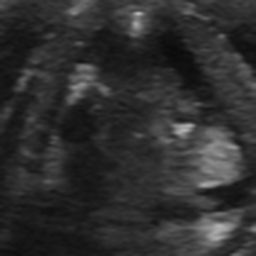

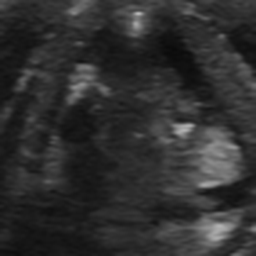

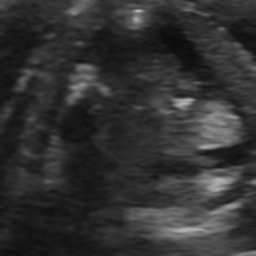

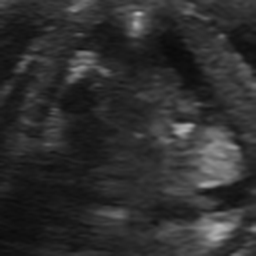

In [12]:
# Set parameters
i = 64
scaleFactor = 1.5
blend_width = 2

# Generate sample images
image = image_list[i]
label_split = image.split('.')
label = os.path.join(source_folder, labels_folder, str(label_split[0]+'.'+label_split[1]+'.txt'))
[healthy, healthy2, left_par, right_par] = crop_and_stretch(os.path.join(images_folder,image), label, scaleFactor, blend_width)

# Display output
healthy.show()
healthy2.show()
left_par.show()
right_par.show()

## Save All Images:

In [18]:
scaleFactor = 1.5
blend_width = 2
for i in range(len(image_list)):
    print('saving batch ',i,' of images')
    image = image_list[i]
    label_split = image.split('.')
    label = os.path.join(source_folder, labels_folder, str(label_split[0]+'.'+label_split[1]+'.txt'))
    print(image)
    print(label)
    [healthy, healthy2, left_par, right_par] = crop_and_stretch(os.path.join(images_folder,image), label, scaleFactor, blend_width)
    
#     print(os.path.join(source_folder, output_folder, 'leftpar_'+str(image)))
    left_par.save(os.path.join(source_folder, output_folder, 'leftpar_'+str(image)), format="PNG")
    right_par.save(os.path.join(source_folder, output_folder, 'rightpar_'+str(image)), format="PNG")
    healthy.save(os.path.join(source_folder, output_folder, 'healthy_'+str(image)), format="PNG")
    healthy2.save(os.path.join(source_folder, output_folder, 'healthy2_'+str(image)), format="PNG")
    print('batch saved succesfully')

saving batch  0  of images
1067.wmv_frame0.png
/data/ai_club/team_13_2024-25/VIPR/Data/YOLO_labels_total/1067.wmv_frame0.txt
batch saved succesfully
saving batch  1  of images
1067.wmv_frame1000.png
/data/ai_club/team_13_2024-25/VIPR/Data/YOLO_labels_total/1067.wmv_frame1000.txt
batch saved succesfully
saving batch  2  of images
1067.wmv_frame1020.png
/data/ai_club/team_13_2024-25/VIPR/Data/YOLO_labels_total/1067.wmv_frame1020.txt
batch saved succesfully
saving batch  3  of images
1067.wmv_frame1040.png
/data/ai_club/team_13_2024-25/VIPR/Data/YOLO_labels_total/1067.wmv_frame1040.txt
batch saved succesfully
saving batch  4  of images
1067.wmv_frame1060.png
/data/ai_club/team_13_2024-25/VIPR/Data/YOLO_labels_total/1067.wmv_frame1060.txt
batch saved succesfully
saving batch  5  of images
1067.wmv_frame1080.png
/data/ai_club/team_13_2024-25/VIPR/Data/YOLO_labels_total/1067.wmv_frame1080.txt
batch saved succesfully
saving batch  6  of images
1067.wmv_frame1100.png
/data/ai_club/team_13_2024

batch saved succesfully
saving batch  57  of images
1067.wmv_frame500.png
/data/ai_club/team_13_2024-25/VIPR/Data/YOLO_labels_total/1067.wmv_frame500.txt
batch saved succesfully
saving batch  58  of images
1067.wmv_frame520.png
/data/ai_club/team_13_2024-25/VIPR/Data/YOLO_labels_total/1067.wmv_frame520.txt
batch saved succesfully
saving batch  59  of images
1067.wmv_frame540.png
/data/ai_club/team_13_2024-25/VIPR/Data/YOLO_labels_total/1067.wmv_frame540.txt
batch saved succesfully
saving batch  60  of images
1067.wmv_frame560.png
/data/ai_club/team_13_2024-25/VIPR/Data/YOLO_labels_total/1067.wmv_frame560.txt
batch saved succesfully
saving batch  61  of images
1067.wmv_frame580.png
/data/ai_club/team_13_2024-25/VIPR/Data/YOLO_labels_total/1067.wmv_frame580.txt
batch saved succesfully
saving batch  62  of images
1067.wmv_frame600.png
/data/ai_club/team_13_2024-25/VIPR/Data/YOLO_labels_total/1067.wmv_frame600.txt
batch saved succesfully
saving batch  63  of images
1067.wmv_frame620.png
/d

batch saved succesfully
saving batch  112  of images
1524.wmv_frame1640.png
/data/ai_club/team_13_2024-25/VIPR/Data/YOLO_labels_total/1524.wmv_frame1640.txt
batch saved succesfully
saving batch  113  of images
1524.wmv_frame1660.png
/data/ai_club/team_13_2024-25/VIPR/Data/YOLO_labels_total/1524.wmv_frame1660.txt
batch saved succesfully
saving batch  114  of images
1524.wmv_frame1680.png
/data/ai_club/team_13_2024-25/VIPR/Data/YOLO_labels_total/1524.wmv_frame1680.txt
batch saved succesfully
saving batch  115  of images
1524.wmv_frame1700.png
/data/ai_club/team_13_2024-25/VIPR/Data/YOLO_labels_total/1524.wmv_frame1700.txt
batch saved succesfully
saving batch  116  of images
1524.wmv_frame1720.png
/data/ai_club/team_13_2024-25/VIPR/Data/YOLO_labels_total/1524.wmv_frame1720.txt
batch saved succesfully
saving batch  117  of images
1524.wmv_frame1740.png
/data/ai_club/team_13_2024-25/VIPR/Data/YOLO_labels_total/1524.wmv_frame1740.txt
batch saved succesfully
saving batch  118  of images
1524.

batch saved succesfully
saving batch  168  of images
1622.wmv_frame1160.png
/data/ai_club/team_13_2024-25/VIPR/Data/YOLO_labels_total/1622.wmv_frame1160.txt
batch saved succesfully
saving batch  169  of images
1622.wmv_frame1180.png
/data/ai_club/team_13_2024-25/VIPR/Data/YOLO_labels_total/1622.wmv_frame1180.txt
batch saved succesfully
saving batch  170  of images
1622.wmv_frame120.png
/data/ai_club/team_13_2024-25/VIPR/Data/YOLO_labels_total/1622.wmv_frame120.txt
batch saved succesfully
saving batch  171  of images
1622.wmv_frame1200.png
/data/ai_club/team_13_2024-25/VIPR/Data/YOLO_labels_total/1622.wmv_frame1200.txt
batch saved succesfully
saving batch  172  of images
1622.wmv_frame180.png
/data/ai_club/team_13_2024-25/VIPR/Data/YOLO_labels_total/1622.wmv_frame180.txt
batch saved succesfully
saving batch  173  of images
1622.wmv_frame960.png
/data/ai_club/team_13_2024-25/VIPR/Data/YOLO_labels_total/1622.wmv_frame960.txt
batch saved succesfully
saving batch  174  of images
1622.wmv_fr

batch saved succesfully
saving batch  221  of images
1657.wmv_frame980.png
/data/ai_club/team_13_2024-25/VIPR/Data/YOLO_labels_total/1657.wmv_frame980.txt
batch saved succesfully
saving batch  222  of images
2290.wmv_frame0.png
/data/ai_club/team_13_2024-25/VIPR/Data/YOLO_labels_total/2290.wmv_frame0.txt
batch saved succesfully
saving batch  223  of images
2290.wmv_frame100.png
/data/ai_club/team_13_2024-25/VIPR/Data/YOLO_labels_total/2290.wmv_frame100.txt
batch saved succesfully
saving batch  224  of images
2290.wmv_frame1000.png
/data/ai_club/team_13_2024-25/VIPR/Data/YOLO_labels_total/2290.wmv_frame1000.txt
batch saved succesfully
saving batch  225  of images
2290.wmv_frame1020.png
/data/ai_club/team_13_2024-25/VIPR/Data/YOLO_labels_total/2290.wmv_frame1020.txt
batch saved succesfully
saving batch  226  of images
2290.wmv_frame1040.png
/data/ai_club/team_13_2024-25/VIPR/Data/YOLO_labels_total/2290.wmv_frame1040.txt
batch saved succesfully
saving batch  227  of images
2290.wmv_frame1

batch saved succesfully
saving batch  277  of images
2290.wmv_frame360.png
/data/ai_club/team_13_2024-25/VIPR/Data/YOLO_labels_total/2290.wmv_frame360.txt
batch saved succesfully
saving batch  278  of images
2290.wmv_frame40.png
/data/ai_club/team_13_2024-25/VIPR/Data/YOLO_labels_total/2290.wmv_frame40.txt
batch saved succesfully
saving batch  279  of images
2290.wmv_frame400.png
/data/ai_club/team_13_2024-25/VIPR/Data/YOLO_labels_total/2290.wmv_frame400.txt
batch saved succesfully
saving batch  280  of images
2290.wmv_frame420.png
/data/ai_club/team_13_2024-25/VIPR/Data/YOLO_labels_total/2290.wmv_frame420.txt
batch saved succesfully
saving batch  281  of images
2290.wmv_frame440.png
/data/ai_club/team_13_2024-25/VIPR/Data/YOLO_labels_total/2290.wmv_frame440.txt
batch saved succesfully
saving batch  282  of images
2290.wmv_frame460.png
/data/ai_club/team_13_2024-25/VIPR/Data/YOLO_labels_total/2290.wmv_frame460.txt
batch saved succesfully
saving batch  283  of images
2290.wmv_frame480.p

batch saved succesfully
saving batch  332  of images
2630.wmv_frame500.png
/data/ai_club/team_13_2024-25/VIPR/Data/YOLO_labels_total/2630.wmv_frame500.txt
batch saved succesfully
saving batch  333  of images
2630.wmv_frame520.png
/data/ai_club/team_13_2024-25/VIPR/Data/YOLO_labels_total/2630.wmv_frame520.txt
batch saved succesfully
saving batch  334  of images
2630.wmv_frame540.png
/data/ai_club/team_13_2024-25/VIPR/Data/YOLO_labels_total/2630.wmv_frame540.txt
batch saved succesfully
saving batch  335  of images
2630.wmv_frame560.png
/data/ai_club/team_13_2024-25/VIPR/Data/YOLO_labels_total/2630.wmv_frame560.txt
batch saved succesfully
saving batch  336  of images
2630.wmv_frame580.png
/data/ai_club/team_13_2024-25/VIPR/Data/YOLO_labels_total/2630.wmv_frame580.txt
batch saved succesfully
saving batch  337  of images
2630.wmv_frame620.png
/data/ai_club/team_13_2024-25/VIPR/Data/YOLO_labels_total/2630.wmv_frame620.txt
batch saved succesfully
saving batch  338  of images
2630.wmv_frame640

batch saved succesfully
saving batch  385  of images
3998.wmv_frame100.png
/data/ai_club/team_13_2024-25/VIPR/Data/YOLO_labels_total/3998.wmv_frame100.txt
batch saved succesfully
saving batch  386  of images
3998.wmv_frame1000.png
/data/ai_club/team_13_2024-25/VIPR/Data/YOLO_labels_total/3998.wmv_frame1000.txt
batch saved succesfully
saving batch  387  of images
3998.wmv_frame1020.png
/data/ai_club/team_13_2024-25/VIPR/Data/YOLO_labels_total/3998.wmv_frame1020.txt
batch saved succesfully
saving batch  388  of images
3998.wmv_frame1040.png
/data/ai_club/team_13_2024-25/VIPR/Data/YOLO_labels_total/3998.wmv_frame1040.txt
batch saved succesfully
saving batch  389  of images
3998.wmv_frame1080.png
/data/ai_club/team_13_2024-25/VIPR/Data/YOLO_labels_total/3998.wmv_frame1080.txt
batch saved succesfully
saving batch  390  of images
3998.wmv_frame1100.png
/data/ai_club/team_13_2024-25/VIPR/Data/YOLO_labels_total/3998.wmv_frame1100.txt
batch saved succesfully
saving batch  391  of images
3998.wm

batch saved succesfully
saving batch  439  of images
3998.wmv_frame700.png
/data/ai_club/team_13_2024-25/VIPR/Data/YOLO_labels_total/3998.wmv_frame700.txt
batch saved succesfully
saving batch  440  of images
3998.wmv_frame720.png
/data/ai_club/team_13_2024-25/VIPR/Data/YOLO_labels_total/3998.wmv_frame720.txt
batch saved succesfully
saving batch  441  of images
3998.wmv_frame880.png
/data/ai_club/team_13_2024-25/VIPR/Data/YOLO_labels_total/3998.wmv_frame880.txt
batch saved succesfully
saving batch  442  of images
3998.wmv_frame960.png
/data/ai_club/team_13_2024-25/VIPR/Data/YOLO_labels_total/3998.wmv_frame960.txt
batch saved succesfully
saving batch  443  of images
3998.wmv_frame980.png
/data/ai_club/team_13_2024-25/VIPR/Data/YOLO_labels_total/3998.wmv_frame980.txt
batch saved succesfully
saving batch  444  of images
4427.wmv_frame0.png
/data/ai_club/team_13_2024-25/VIPR/Data/YOLO_labels_total/4427.wmv_frame0.txt
batch saved succesfully
saving batch  445  of images
4427.wmv_frame100.png

batch saved succesfully
saving batch  492  of images
4427.wmv_frame340.png
/data/ai_club/team_13_2024-25/VIPR/Data/YOLO_labels_total/4427.wmv_frame340.txt
batch saved succesfully
saving batch  493  of images
4427.wmv_frame360.png
/data/ai_club/team_13_2024-25/VIPR/Data/YOLO_labels_total/4427.wmv_frame360.txt
batch saved succesfully
saving batch  494  of images
4427.wmv_frame380.png
/data/ai_club/team_13_2024-25/VIPR/Data/YOLO_labels_total/4427.wmv_frame380.txt
batch saved succesfully
saving batch  495  of images
4427.wmv_frame400.png
/data/ai_club/team_13_2024-25/VIPR/Data/YOLO_labels_total/4427.wmv_frame400.txt
batch saved succesfully
saving batch  496  of images
4427.wmv_frame420.png
/data/ai_club/team_13_2024-25/VIPR/Data/YOLO_labels_total/4427.wmv_frame420.txt
batch saved succesfully
saving batch  497  of images
4427.wmv_frame440.png
/data/ai_club/team_13_2024-25/VIPR/Data/YOLO_labels_total/4427.wmv_frame440.txt
batch saved succesfully
saving batch  498  of images
4427.wmv_frame480

batch saved succesfully
saving batch  548  of images
4505.wmv_frame900.png
/data/ai_club/team_13_2024-25/VIPR/Data/YOLO_labels_total/4505.wmv_frame900.txt
batch saved succesfully
saving batch  549  of images
4505.wmv_frame920.png
/data/ai_club/team_13_2024-25/VIPR/Data/YOLO_labels_total/4505.wmv_frame920.txt
batch saved succesfully
saving batch  550  of images
4505.wmv_frame940.png
/data/ai_club/team_13_2024-25/VIPR/Data/YOLO_labels_total/4505.wmv_frame940.txt
batch saved succesfully
saving batch  551  of images
4505.wmv_frame960.png
/data/ai_club/team_13_2024-25/VIPR/Data/YOLO_labels_total/4505.wmv_frame960.txt
batch saved succesfully
saving batch  552  of images
4505.wmv_frame980.png
/data/ai_club/team_13_2024-25/VIPR/Data/YOLO_labels_total/4505.wmv_frame980.txt
batch saved succesfully
saving batch  553  of images
4700.wmv_frame0.png
/data/ai_club/team_13_2024-25/VIPR/Data/YOLO_labels_total/4700.wmv_frame0.txt
batch saved succesfully
saving batch  554  of images
4700.wmv_frame100.png

batch saved succesfully
saving batch  601  of images
4700.wmv_frame300.png
/data/ai_club/team_13_2024-25/VIPR/Data/YOLO_labels_total/4700.wmv_frame300.txt
batch saved succesfully
saving batch  602  of images
4700.wmv_frame320.png
/data/ai_club/team_13_2024-25/VIPR/Data/YOLO_labels_total/4700.wmv_frame320.txt
batch saved succesfully
saving batch  603  of images
4700.wmv_frame360.png
/data/ai_club/team_13_2024-25/VIPR/Data/YOLO_labels_total/4700.wmv_frame360.txt
batch saved succesfully
saving batch  604  of images
4700.wmv_frame380.png
/data/ai_club/team_13_2024-25/VIPR/Data/YOLO_labels_total/4700.wmv_frame380.txt
batch saved succesfully
saving batch  605  of images
4700.wmv_frame40.png
/data/ai_club/team_13_2024-25/VIPR/Data/YOLO_labels_total/4700.wmv_frame40.txt
batch saved succesfully
saving batch  606  of images
4700.wmv_frame400.png
/data/ai_club/team_13_2024-25/VIPR/Data/YOLO_labels_total/4700.wmv_frame400.txt
batch saved succesfully
saving batch  607  of images
4700.wmv_frame420.p

batch saved succesfully
saving batch  657  of images
5285.wmv_frame1720.png
/data/ai_club/team_13_2024-25/VIPR/Data/YOLO_labels_total/5285.wmv_frame1720.txt
batch saved succesfully
saving batch  658  of images
5285.wmv_frame1740.png
/data/ai_club/team_13_2024-25/VIPR/Data/YOLO_labels_total/5285.wmv_frame1740.txt
batch saved succesfully
saving batch  659  of images
5285.wmv_frame1760.png
/data/ai_club/team_13_2024-25/VIPR/Data/YOLO_labels_total/5285.wmv_frame1760.txt
batch saved succesfully
saving batch  660  of images
5285.wmv_frame180.png
/data/ai_club/team_13_2024-25/VIPR/Data/YOLO_labels_total/5285.wmv_frame180.txt
batch saved succesfully
saving batch  661  of images
5285.wmv_frame200.png
/data/ai_club/team_13_2024-25/VIPR/Data/YOLO_labels_total/5285.wmv_frame200.txt
batch saved succesfully
saving batch  662  of images
5285.wmv_frame220.png
/data/ai_club/team_13_2024-25/VIPR/Data/YOLO_labels_total/5285.wmv_frame220.txt
batch saved succesfully
saving batch  663  of images
5285.wmv_fr

batch saved succesfully
saving batch  713  of images
5383.wmv_frame1360.png
/data/ai_club/team_13_2024-25/VIPR/Data/YOLO_labels_total/5383.wmv_frame1360.txt
batch saved succesfully
saving batch  714  of images
5383.wmv_frame1380.png
/data/ai_club/team_13_2024-25/VIPR/Data/YOLO_labels_total/5383.wmv_frame1380.txt
batch saved succesfully
saving batch  715  of images
5383.wmv_frame140.png
/data/ai_club/team_13_2024-25/VIPR/Data/YOLO_labels_total/5383.wmv_frame140.txt
batch saved succesfully
saving batch  716  of images
5383.wmv_frame1400.png
/data/ai_club/team_13_2024-25/VIPR/Data/YOLO_labels_total/5383.wmv_frame1400.txt
batch saved succesfully
saving batch  717  of images
5383.wmv_frame1460.png
/data/ai_club/team_13_2024-25/VIPR/Data/YOLO_labels_total/5383.wmv_frame1460.txt
batch saved succesfully
saving batch  718  of images
5383.wmv_frame1480.png
/data/ai_club/team_13_2024-25/VIPR/Data/YOLO_labels_total/5383.wmv_frame1480.txt
batch saved succesfully
saving batch  719  of images
5383.wm

batch saved succesfully
saving batch  769  of images
5383.wmv_frame940.png
/data/ai_club/team_13_2024-25/VIPR/Data/YOLO_labels_total/5383.wmv_frame940.txt
batch saved succesfully
saving batch  770  of images
5383.wmv_frame960.png
/data/ai_club/team_13_2024-25/VIPR/Data/YOLO_labels_total/5383.wmv_frame960.txt
batch saved succesfully
saving batch  771  of images
5383.wmv_frame980.png
/data/ai_club/team_13_2024-25/VIPR/Data/YOLO_labels_total/5383.wmv_frame980.txt
batch saved succesfully
saving batch  772  of images
6020.wmv_frame0.png
/data/ai_club/team_13_2024-25/VIPR/Data/YOLO_labels_total/6020.wmv_frame0.txt
batch saved succesfully
saving batch  773  of images
6020.wmv_frame100.png
/data/ai_club/team_13_2024-25/VIPR/Data/YOLO_labels_total/6020.wmv_frame100.txt
batch saved succesfully
saving batch  774  of images
6020.wmv_frame1000.png
/data/ai_club/team_13_2024-25/VIPR/Data/YOLO_labels_total/6020.wmv_frame1000.txt
batch saved succesfully
saving batch  775  of images
6020.wmv_frame1020.

batch saved succesfully
saving batch  825  of images
6541.wmv_frame100.png
/data/ai_club/team_13_2024-25/VIPR/Data/YOLO_labels_total/6541.wmv_frame100.txt
batch saved succesfully
saving batch  826  of images
6541.wmv_frame1000.png
/data/ai_club/team_13_2024-25/VIPR/Data/YOLO_labels_total/6541.wmv_frame1000.txt
batch saved succesfully
saving batch  827  of images
6541.wmv_frame1020.png
/data/ai_club/team_13_2024-25/VIPR/Data/YOLO_labels_total/6541.wmv_frame1020.txt
batch saved succesfully
saving batch  828  of images
6541.wmv_frame1040.png
/data/ai_club/team_13_2024-25/VIPR/Data/YOLO_labels_total/6541.wmv_frame1040.txt
batch saved succesfully
saving batch  829  of images
6541.wmv_frame1060.png
/data/ai_club/team_13_2024-25/VIPR/Data/YOLO_labels_total/6541.wmv_frame1060.txt
batch saved succesfully
saving batch  830  of images
6541.wmv_frame1080.png
/data/ai_club/team_13_2024-25/VIPR/Data/YOLO_labels_total/6541.wmv_frame1080.txt
batch saved succesfully
saving batch  831  of images
6541.wm

batch saved succesfully
saving batch  880  of images
6541.wmv_frame420.png
/data/ai_club/team_13_2024-25/VIPR/Data/YOLO_labels_total/6541.wmv_frame420.txt
batch saved succesfully
saving batch  881  of images
6541.wmv_frame440.png
/data/ai_club/team_13_2024-25/VIPR/Data/YOLO_labels_total/6541.wmv_frame440.txt
batch saved succesfully
saving batch  882  of images
6541.wmv_frame480.png
/data/ai_club/team_13_2024-25/VIPR/Data/YOLO_labels_total/6541.wmv_frame480.txt
batch saved succesfully
saving batch  883  of images
6541.wmv_frame500.png
/data/ai_club/team_13_2024-25/VIPR/Data/YOLO_labels_total/6541.wmv_frame500.txt
batch saved succesfully
saving batch  884  of images
6541.wmv_frame520.png
/data/ai_club/team_13_2024-25/VIPR/Data/YOLO_labels_total/6541.wmv_frame520.txt
batch saved succesfully
saving batch  885  of images
6541.wmv_frame540.png
/data/ai_club/team_13_2024-25/VIPR/Data/YOLO_labels_total/6541.wmv_frame540.txt
batch saved succesfully
saving batch  886  of images
6541.wmv_frame560

batch saved succesfully
saving batch  933  of images
8173.wmv_frame340.png
/data/ai_club/team_13_2024-25/VIPR/Data/YOLO_labels_total/8173.wmv_frame340.txt
batch saved succesfully
saving batch  934  of images
8173.wmv_frame360.png
/data/ai_club/team_13_2024-25/VIPR/Data/YOLO_labels_total/8173.wmv_frame360.txt
batch saved succesfully
saving batch  935  of images
8173.wmv_frame380.png
/data/ai_club/team_13_2024-25/VIPR/Data/YOLO_labels_total/8173.wmv_frame380.txt
batch saved succesfully
saving batch  936  of images
8173.wmv_frame40.png
/data/ai_club/team_13_2024-25/VIPR/Data/YOLO_labels_total/8173.wmv_frame40.txt
batch saved succesfully
saving batch  937  of images
8173.wmv_frame400.png
/data/ai_club/team_13_2024-25/VIPR/Data/YOLO_labels_total/8173.wmv_frame400.txt
batch saved succesfully
saving batch  938  of images
8173.wmv_frame440.png
/data/ai_club/team_13_2024-25/VIPR/Data/YOLO_labels_total/8173.wmv_frame440.txt
batch saved succesfully
saving batch  939  of images
8173.wmv_frame460.p

batch saved succesfully
saving batch  989  of images
9961.wmv_frame160.png
/data/ai_club/team_13_2024-25/VIPR/Data/YOLO_labels_total/9961.wmv_frame160.txt
batch saved succesfully
saving batch  990  of images
9961.wmv_frame1620.png
/data/ai_club/team_13_2024-25/VIPR/Data/YOLO_labels_total/9961.wmv_frame1620.txt
batch saved succesfully
saving batch  991  of images
9961.wmv_frame1640.png
/data/ai_club/team_13_2024-25/VIPR/Data/YOLO_labels_total/9961.wmv_frame1640.txt
batch saved succesfully
saving batch  992  of images
9961.wmv_frame1660.png
/data/ai_club/team_13_2024-25/VIPR/Data/YOLO_labels_total/9961.wmv_frame1660.txt
batch saved succesfully
saving batch  993  of images
9961.wmv_frame1680.png
/data/ai_club/team_13_2024-25/VIPR/Data/YOLO_labels_total/9961.wmv_frame1680.txt
batch saved succesfully
saving batch  994  of images
9961.wmv_frame1700.png
/data/ai_club/team_13_2024-25/VIPR/Data/YOLO_labels_total/9961.wmv_frame1700.txt
batch saved succesfully
saving batch  995  of images
9961.wm